## classification model

In [1]:

'''
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn

import pandas as pd
import numpy as np
import logging
from datasets import Dataset, DatasetDict
from transformers import DistilBertModel
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

COVERWALLET_DF_PATH = '../src/data/coverwallet.xlsx'
df = pd.read_excel(COVERWALLET_DF_PATH)
df = df.dropna()
def truncate_naics_and_prepare_data(df, column_name, num_digits):
    """
    Truncates the NAICS codes in the specified column to the desired number of digits and prepares the data.

    :param df: pandas DataFrame containing the NAICS codes.
    :param column_name: the name of the column with the NAICS codes.
    :param num_digits: the number of digits to truncate to.
    :return: A modified DataFrame with truncated NAICS codes, and split datasets for training and validation.
    """
    # Validate the number of digits
    if not isinstance(num_digits, int) or num_digits <= 0:
        logging.error("Number of digits must be a positive integer")
        raise ValueError("Number of digits must be a positive integer")

    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Function to truncate or pad NAICS codes
    def truncate_code(code):
        """
        Truncates the NAICS code to the specified number of digits.
        :param code: the NAICS code to be truncated.
        :return: The truncated NAICS code as a string.
        """
        try:
            # Ensure the code is a string and truncate if longer than num_digits
            return str(code)[:num_digits]
        except Exception as e:
            logging.exception(f"Error truncating code: {code}")
            return code

    # Apply the truncation function to the specified column
    df_copy[column_name] = df_copy[column_name].apply(truncate_code)

    # Ensure all NAICS codes are still strings
    df_copy[column_name] = df_copy[column_name].astype(str)

    # Add a logging statement to check the result
    logging.info("NAICS codes processed successfully. Here's the head of the processed DataFrame:")
    logging.info(df_copy.head())

    # Split the data into training and validation sets
    df_copy_train, df_copy_val = train_test_split(df_copy, test_size=0.15, shuffle=True, random_state=42)

    # Return the processed DataFrame and the split datasets
    return df_copy, df_copy_train, df_copy_val

    # Configuration k-fold
    num_folds = 3
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    kfold_datasets = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset_train)):
        train_dataset = dataset_train.select(train_indices)
        val_dataset = dataset_train.select(val_indices)

        dataset_dict = {
            'train': train_dataset,
            'validation': val_dataset
        }

        features_dict = {
            "NAICS": dataset_train["NAICS"],
            "BUSINESS_DESCRIPTION": dataset_train["BUSINESS_DESCRIPTION"],
        }

        kfold_datasets.append(dataset_dict)
        logging.info(f"Processed fold {fold + 1}")

    for i, dataset_dict in enumerate(kfold_datasets):
        for split in dataset_dict.keys():
            dataset_dict[split] = dataset_dict[split].map(lambda example: {key: example[key] for key in features_dict.keys()})

        logging.info(f"DatasetDict for Fold {i + 1}:")
        for split, dataset in dataset_dict.items():
            logging.info(f"  {split} split: {dataset}")

    logging.info("NAICS codes truncated successfully. Here's the head of the truncated DataFrame:")
    logging.info("\n%s", df_copy.head())
    logging.info("Number of unique NAICS labels: %d", len(labels))
    
    #return df_copy, kfold_datasets, dataset_train, dataset_final_val

    #df_2_digits, kfold_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)
df_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)


def count_low_freq_naics_verbose(df, naics_column):
    """
    Counts and prints the number of NAICS codes that appear less than 20, 30, 40, ..., up to 1000 times in the DataFrame.

    :param df: DataFrame with the NAICS codes.
    :param naics_column: Column name where the NAICS codes are stored.
    :return: A summary string indicating if the data seems balanced or not.
    """
    # Count occurrences of each NAICS code
    naics_counts = df[naics_column].value_counts()
    
    # Initialize a dictionary to hold the results
    thresholds = list(range(20, 1001, 10))
    results = {}
    
    for threshold in thresholds:
        # Filter counts where occurrences are less than the current threshold
        count_below_threshold = naics_counts[naics_counts < threshold].count()
        results[threshold] = count_below_threshold
        print(f'NAICS codes with less than {threshold} appearances: {count_below_threshold}')
    
    # Analyze the distribution to provide a conclusion
    if results[20] > 0.5 * len(naics_counts):
        conclusion = "The data seems highly imbalanced towards low-frequency NAICS codes."
    elif results[1000] == len(naics_counts):
        conclusion = "The data seems balanced as no NAICS codes appear less than 1000 times."
    else:
        conclusion = "There is a moderate distribution of NAICS code appearances across different frequencies."

    return conclusion

print(count_low_freq_naics_verbose(df_2_digits, 'NAICS'))

'''
import pandas as pd
import logging

ROUTE_SYNTHETIC= '../src/data/synthetic_preprocessed.parquet'
df = pd.read_parquet(ROUTE_SYNTHETIC)
df = df[['BUSINESS_DESCRIPTION', 'NAICS_2']]
df.rename(columns={'NAICS_2': 'NAICS'}, inplace=True)
print(df.head())
print(df.columns)
df_synthetic=df
naics_counts = df['NAICS'].value_counts()

# Imprimir los resultados
print("Número de filas por cada código NAICS:")
print(naics_counts)
'''
# Configurando el logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_process_data(parquet_path):
    # Cargar el DataFrame desde un archivo CSV
    df = pd.read_parquet(parquet_path)
    
    # Logear la longitud del DataFrame original
    logging.info(f"Longitud del DataFrame original: {len(df)}")
    
    # Logear las primeras filas del DataFrame original
    logging.info(f"Primeras filas del DataFrame original:\n{df.head()}")
    
    # Remover la columna 'naics'
    df.drop(columns=['naics'], inplace=True)
    
    # Renombrar las columnas especificadas
    df.rename(columns={'naics_2': 'NAICS', 'description': 'BUSINESS_DESCRIPTION'}, inplace=True)
    
    # Logear las primeras filas del DataFrame modificado
    logging.info(f"Primeras filas del DataFrame modificado:\n{df.head()}")
    
    # Imprimir el conteo de filas por NAICS
    count_per_naics = df['NAICS'].value_counts()
    print("Número de filas por NAICS:")
    print(count_per_naics)
    
    return df

# Llamada de ejemplo a la función
ROUTE_SYNTHETIC= '../src/data/synthetic_preprocessed.parquet'
df_synthetic = load_and_process_data(ROUTE_SYNTHETIC)
''' 


                                BUSINESS_DESCRIPTION  NAICS
0  This establishment is engaged in the explorati...     21
1  This business is involved in the mining and qu...     21
2  This company specializes in the mining and pro...     21
3  This establishment is engaged in the explorati...     21
4  This business provides support services for oi...     21
Index(['BUSINESS_DESCRIPTION', 'NAICS'], dtype='object')
Número de filas por cada código NAICS:
NAICS
55    260
21    240
22    240
11    210
92    200
49    109
52    100
44    100
48     91
31     76
32     18
33      6
Name: count, dtype: int64


'\n# Configurando el logging\nlogging.basicConfig(level=logging.INFO, format=\'%(asctime)s - %(levelname)s - %(message)s\')\n\ndef load_and_process_data(parquet_path):\n    # Cargar el DataFrame desde un archivo CSV\n    df = pd.read_parquet(parquet_path)\n    \n    # Logear la longitud del DataFrame original\n    logging.info(f"Longitud del DataFrame original: {len(df)}")\n    \n    # Logear las primeras filas del DataFrame original\n    logging.info(f"Primeras filas del DataFrame original:\n{df.head()}")\n    \n    # Remover la columna \'naics\'\n    df.drop(columns=[\'naics\'], inplace=True)\n    \n    # Renombrar las columnas especificadas\n    df.rename(columns={\'naics_2\': \'NAICS\', \'description\': \'BUSINESS_DESCRIPTION\'}, inplace=True)\n    \n    # Logear las primeras filas del DataFrame modificado\n    logging.info(f"Primeras filas del DataFrame modificado:\n{df.head()}")\n    \n    # Imprimir el conteo de filas por NAICS\n    count_per_naics = df[\'NAICS\'].value_counts()

[nltk_data] Downloading package wordnet to /home/edu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-04-23 22:56:58,705 - INFO - Number of rows before EDA: 14182
2024-04-23 22:56:58,706 - INFO - Number of rows after EDA: 11647


NAICS
23    1500
54    1500
56    1159
61     751
33     688
42     650
62     517
81     488
51     380
48     361
72     333
53     331
71     300
55     275
22     272
52     262
31     260
32     259
21     253
44     248
45     240
11     236
92     230
49     154
Name: count, dtype: int64


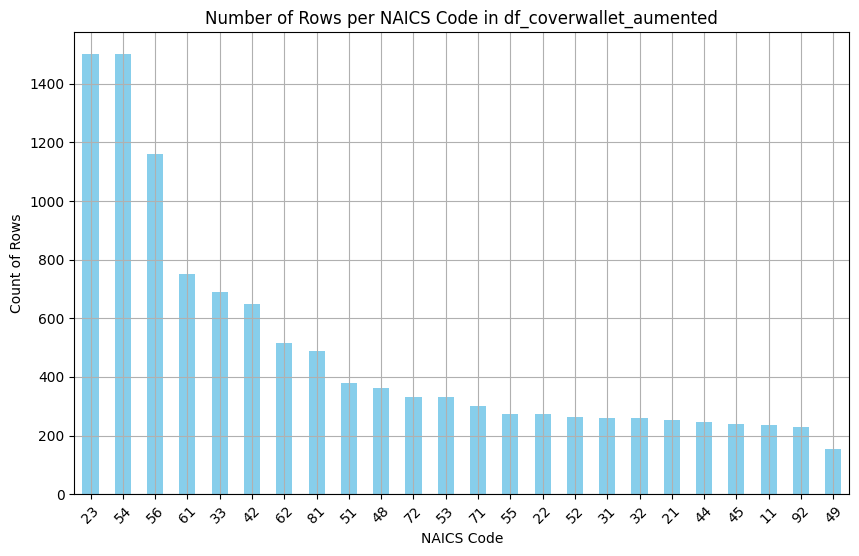

      NAICS                               BUSINESS_DESCRIPTION
10079    11  A greenhouse and nursery operation that grows ...
10098    11  An avocado farm utilizing water-efficient irri...
11334    11  A forestry support service specializing in ref...
10097    11  A diversified farm specializing in the product...
11335    11  A wildlife management service dedicated to the...


In [8]:

import pandas as pd
import random
from typing import List, Set
from nltk.corpus import wordnet as wn
from nltk import download
import logging
from sklearn.model_selection import train_test_split
from typing import Tuple

ROUTE_COVERWALLET= '../src/data/coverwallet.xlsx'

    
 

class NAICSRebalancer:
    def __init__(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        download('wordnet')

    def get_synonyms(self, word: str) -> List[str]:
        synonyms: Set[str] = set()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                synonyms.add(synonym)
        synonyms.discard(word)
        return list(synonyms)

    def random_swap(self, sentence: str, n: int) -> str:
        words = sentence.split()
        n = min(n, len(words) // 2)
        for _ in range(n):
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
        return ' '.join(words)

    def augment_description(self, description: str) -> str:
        words = description.split()
        if len(words) < 2:
            return description
        
        new_description = description
        num_swaps = random.randint(1, max(2, len(words) // 2))
        swapped_words = set()
        
        for _ in range(num_swaps):
            swap_word = random.choice(words)
            if swap_word in swapped_words:
                continue
            synonyms = self.get_synonyms(swap_word)
            if synonyms:
                new_word = random.choice(synonyms)
                new_description = new_description.replace(swap_word, new_word, 1)
                swapped_words.add(swap_word)
        
        return self.random_swap(new_description, n=num_swaps)

    def rebalance_df_naics(self, df: pd.DataFrame) -> pd.DataFrame:
        df_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)
        naics_counts = df_2_digits['NAICS'].value_counts()
        underrepresented_naics = naics_counts[naics_counts < 10].index
        overrepresented_naics = naics_counts[naics_counts > 1500].index
        new_rows = []

        for naics_code in underrepresented_naics:
            needed_rows = 10 - naics_counts[naics_code]
            original_rows = df_2_digits[df_2_digits['NAICS'] == naics_code]
            while needed_rows > 0:
                for _, row in original_rows.iterrows():
                    if needed_rows <= 0:
                        break
                    new_description = self.augment_description(row['BUSINESS_DESCRIPTION'])
                    new_rows.append({'NAICS': naics_code, 'BUSINESS_DESCRIPTION': new_description})
                    needed_rows -= 1

        for naics_code in overrepresented_naics:
            rows_to_keep = df_2_digits[df_2_digits['NAICS'] == naics_code].sample(n=1500, random_state=42)
            df_2_digits = pd.concat([df_2_digits[df_2_digits['NAICS'] != naics_code], rows_to_keep], ignore_index=True)

        new_rows_df = pd.DataFrame(new_rows)
        df_2_digits = pd.concat([df_2_digits, new_rows_df], ignore_index=True)

        return df_2_digits
    
def truncate_naics_and_prepare_data(df: pd.DataFrame, column_name: str, num_digits: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    df=df.dropna()
   
    
    if not isinstance(num_digits, int) or num_digits <= 0:
        logging.error("Number of digits must be a positive integer")
        raise ValueError("Number of digits must be a positive integer")

    df_coverwallet_copy = df.copy()

    def truncate_code(code):
        try:
            return str(code)[:num_digits]
        except Exception as e:
            logging.exception(f"Error truncating code: {code}")
            return code

    df_coverwallet_copy [column_name] = df_coverwallet_copy [column_name].apply(truncate_code)

    df_coverwallet_copy [column_name] = df_coverwallet_copy [column_name].astype(str)

    df_coverwallet_copy_train, df_coverwallet_copy_val = train_test_split(df_coverwallet_copy , test_size=0.15, shuffle=True, random_state=42)
    
    


   

    return df_coverwallet_copy , df_coverwallet_copy_train, df_coverwallet_copy_val




df_coverwallet_aumentation = pd.read_excel(ROUTE_COVERWALLET)
rebalancer = NAICSRebalancer()
df_naics_rebalanced = rebalancer.rebalance_df_naics(df_coverwallet_aumentation)
df_coverwallet_aumented = pd.concat([df_naics_rebalanced, df_synthetic], ignore_index=True)

# Asegurarse de que los códigos NAICS estén en el mismo formato
df_coverwallet_aumented['NAICS'] = df_coverwallet_aumented['NAICS'].astype(str)

# Ordenar por NAICS para visualizar mejor cómo se agrupan las entradas
df_coverwallet_aumented.sort_values(by='NAICS', inplace=True)

# Información de logging antes y después de la manipulación de datos
logging.info(f"Number of rows before EDA: {len(df_coverwallet_aumentation)}")
logging.info(f"Number of rows after EDA: {len(df_coverwallet_aumented)}")

# Conteo de NAICS y visualización
naics_counts = df_coverwallet_aumented['NAICS'].value_counts()
print(naics_counts)

naics_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('NAICS Code')
plt.ylabel('Count of Rows')
plt.title('Number of Rows per NAICS Code in df_coverwallet_aumented')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Muestra de las primeras filas para revisar
print(df_coverwallet_aumented.head())
df_2_digits=df_coverwallet_aumented



In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity


class CustomDataset(Dataset):
    
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = np.array(dataframe['BUSINESS_DESCRIPTION'].astype(str))
        self.targets = np.array(dataframe['NAICS'].astype(int))
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Agregar una capa de clasificación que será la única que entrenemos
        self.classifier = nn.Linear(self.model.config.dim, len(np.unique(self.targets)))

        # Congelar todos los parámetros del modelo DistilBERT
        for param in self.model.parameters():
            param.requires_grad = False

        # Habilitar entrenamiento solo en la capa clasificadora
        for param in self.classifier.parameters():
            param.requires_grad = True

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Tokenizar el texto y obtener los embeddings con el modelo DistilBERT
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Obtener los embeddings del token [CLS] (última capa oculta)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Embeddings del token [CLS]

        # Aplicar la capa clasificadora
        logits = self.classifier(embeddings)

        label = torch.tensor(target, dtype=torch.long)

        return {
            'embeddings': embeddings,
            'label': label,
        }

In [10]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'



In [11]:

MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
'''
train_size = 0.7
test_size = 0.2
val_size = 0.1
''' 

def dataset_to_dataframe(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        # Assume each item returns a dictionary with 'embeddings' and 'label'
        embeddings = item['embeddings'].squeeze().detach().numpy()  # Converting tensor to numpy array
        label = item['label'].item()  # Getting the scalar value of the label tensor
        # You may want to store more meaningful data depending on your application
        # For demonstration, we'll just store the label and the shape of the embeddings
        data.append({
            'label': label,
            'embeddings': embeddings  
        })
    return pd.DataFrame(data)
'''
train_data = df_2_digits.sample(frac=train_size, random_state=200)
remaining_data = df_2_digits.drop(train_data.index).reset_index(drop=True)
test_data = remaining_data.sample(frac=test_size / (test_size + val_size), random_state=200)
val_data = remaining_data.drop(test_data.index).reset_index(drop=True)

training_set = CustomDataset(train_data, MAX_LEN)
test_set = CustomDataset(test_data, MAX_LEN)
val_set = CustomDataset(val_data, MAX_LEN)

# Convert datasets to DataFrames

df_training = dataset_to_dataframe(training_set)
df_test = dataset_to_dataframe(test_set)
df_val = dataset_to_dataframe(val_set)

logging.info("TRAIN Dataset: %s", df_training.head())
logging.info("TEST Dataset: %s", df_test.head())
logging.info("VALIDATION Dataset: %s", df_val.head())
''' 

data=CustomDataset(df_2_digits, MAX_LEN)

df_embeddings=dataset_to_dataframe(data)
df_2_digits=df_embeddings

logging.info("DF: %s", df_2_digits.head())




'''
def modify_similar_descriptions_vectorized(df, threshold=0.9):
    if 'embeddings' not in df.columns:
        logging.error("DataFrame does not contain the column 'embeddings'.")
        return df

    # Preparar un DataFrame para almacenar los embeddings modificados
    modified_embeddings = pd.DataFrame(index=df.index, columns=['embeddings'])

    # Agrupar por 'label'
    for label, group in df.groupby('label'):
        if len(group) < 2:
            continue
        
        # Crear matriz de embeddings y calcular similitud del coseno
        embeddings_matrix = np.vstack(group['embeddings'])
        cosine_sim = cosine_similarity(embeddings_matrix)

        # Encuentra pares con similitud alta y modifica los embeddings
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                if cosine_sim[i, j] > threshold:
                    # Modificar ambos embeddings solo si no han sido modificados previamente
                    indices = [group.index[i], group.index[j]]
                    for idx in indices:
                        if pd.isna(modified_embeddings.at[idx, 'embeddings']):
                            modified_embedding = embeddings_matrix[i] * 0.99
                            modified_embeddings.at[idx, 'embeddings'] = modified_embedding.tolist()

    # Actualizar los embeddings en el DataFrame original solo donde se realizaron modificaciones
    df.loc[modified_embeddings['embeddings'].notna(), 'embeddings'] = modified_embeddings['embeddings']

    logging.info(f"Modifications applied to {modified_embeddings['embeddings'].notna().sum()} embeddings.")
    return df


df_modified = modify_similar_descriptions_vectorized(df_2_digits)
logging.info(f"Number of rows df_embeddings: {len(df_2_digits)}")
logging.info(f"df head: {(df_2_digits.head())}")

'''


In [5]:
length_of_df_2_digits = len(df_2_digits)
print("Number of rows in df_2_digits:", length_of_df_2_digits)

Number of rows in df_2_digits: 10426


2024-04-23 21:40:22,154 - INFO - F1 Score: 0.668752


Confusion Matrix:
 [[ 18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  28   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   7   2   0   0   1   1   0   0   0   0   1   0   0   0   0   2
    0   0   0   0   0   0]
 [  0   0   2 260   0   6   6   3   0   0   2   0   1   0   2   5   0  10
    0   0   0   1   2   0]
 [  0   0   0   0  16   2   2   5   0   3   0   0   0   0   0   1   0   1
    0   0   0   6   1   0]
 [  0   0   0   1   1  23   2   6   1   6   1   0   0   0   0   3   0   1
    0   2   0   0   1   0]
 [  0   0   1  17   0   4  84  13   3   0   0   0   1   0   0   5   0   3
    0   1   1   0   4   0]
 [  0   0   1   6   5   1  12  72   7   4   1   0   1   0   2   9   0   7
    0   1   0   1   0   0]
 [  0   0   0   3   1   1   2   9   7   2   0   0   0   0   0   0   0   1
    1   0   0   2   1   0]
 [  0   0   0   2   7   1   0  13   1  10   0   0   2   0   1   0   0   

/tmp/ipykernel_26076/1063923153.py:53: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_26076/1063923153.py:53: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_26076/1063923153.py:53: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))


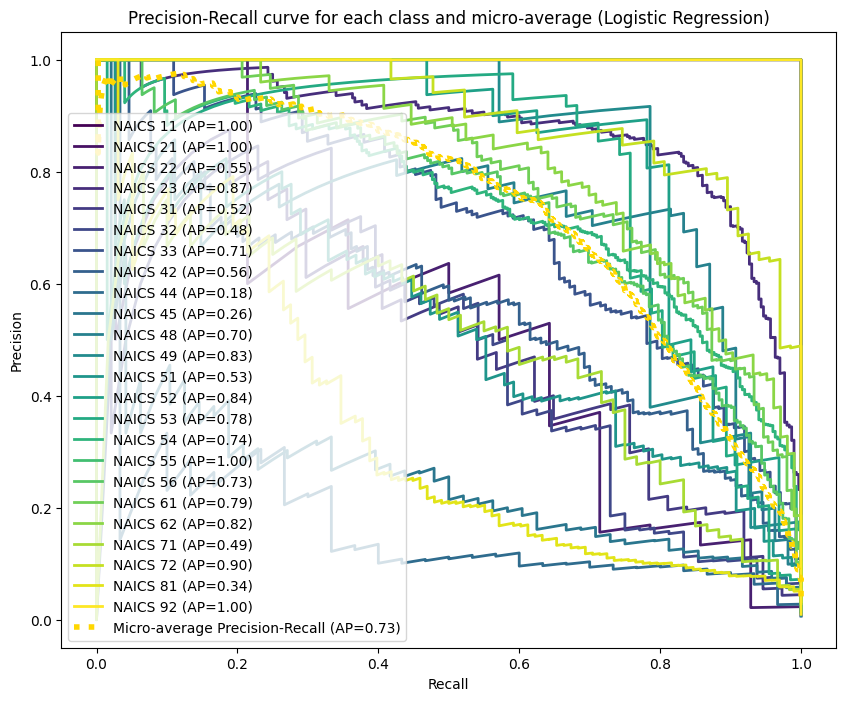

2024-04-23 21:40:23,279 - INFO - Average F1 Score Logistic Regression: 0.700856


' \nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score\nfrom sklearn.model_selection import StratifiedKFold, train_test_split\nfrom sklearn.preprocessing import label_binarize\nfrom itertools import cycle\nimport logging\n\n# Configurar logging para mostrar información de las métricas\nlogging.basicConfig(level=logging.INFO, format=\'%(asctime)s - %(levelname)s - %(message)s\')\n\n# Asumiendo que df_2_digits es el DataFrame con los datos\nX = np.stack(df_2_digits[\'embeddings\'].apply(lambda x: np.array(x).flatten()))\ny = df_2_digits[\'label\'].to_numpy()\n\n# Dividir los datos en un conjunto para cross-validation (90%) y un conjunto final de test (10%)\nX_cross_val, X_final_test, y_cross_val, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)\n\n# Configurando la validación 

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
df_training, df_val = train_test_split(df_2_digits, test_size=0.2, random_state=42, stratify=df_2_digits['label'])

# Preparar los datos de entrenamiento
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

# Preparar los datos de validación
X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()


model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)

# Generar matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)
logging.info("F1 Score: %f", f1)

# Binarizar las etiquetas en un formato one-vs-all
unique_classes = np.unique(y_train)  # Asegúrate de que esto contenga códigos NAICS reales
y_val_binarized = label_binarize(y_val, classes=unique_classes)

# Calcular precisión, recall y F1 para cada clase
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

# Ciclo de colores para la gráfica
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))
plt.figure(figsize=(10, 8))

for i, color in zip(range(len(unique_classes)), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(unique_classes[i], average_precision[i]))  # Usa los códigos NAICS aquí

# Calcular y graficar el micro-average de la curva de precisión-recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Logistic Regression)')
plt.legend(loc="best")
plt.show()

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Logistic Regression: %f", f1_average)
''' 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Asumiendo que df_2_digits es el DataFrame con los datos
X = np.stack(df_2_digits['embeddings'].apply(lambda x: np.array(x).flatten()))
y = df_2_digits['label'].to_numpy()

# Dividir los datos en un conjunto para cross-validation (90%) y un conjunto final de test (10%)
X_cross_val, X_final_test, y_cross_val, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Configurando la validación cruzada sobre el 90% del conjunto
skf = StratifiedKFold(n_splits=5)
f1_scores = []

# Ciclo a través de los pliegues de validación cruzada
for train_index, test_index in skf.split(X_cross_val, y_cross_val):
    X_train, X_test = X_cross_val[train_index], X_cross_val[test_index]
    y_train, y_test = y_cross_val[train_index], y_cross_val[test_index]

    model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Calculando y registrando las métricas por pliegue
    report = classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    logging.info("\n%s\n", report)
    logging.info("F1 Score: %f", f1)

# Calculando el promedio de F1-score de todos los pliegues
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Logistic Regression: %f", f1_average)

# Evaluación en el conjunto final de test
model_final = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model_final.fit(X_cross_val, y_cross_val)  # Entrenamos con todo el conjunto de cross-validation
y_final_pred = model_final.predict(X_final_test)
y_final_proba = model_final.predict_proba(X_final_test)
final_report = classification_report(y_final_test, y_final_pred)
final_f1 = f1_score(y_final_test, y_final_pred, average='weighted')
logging.info("\nFinal Test Set Classification Report:\n%s\n", final_report)
logging.info("Final Test Set F1 Score: %f", final_f1)

# Binarizar las etiquetas del conjunto final para visualización
unique_classes = np.unique(y_cross_val)
y_final_test_binarized = label_binarize(y_final_test, classes=unique_classes)

# Calcular y graficar las métricas para el conjunto final
precision = dict()
recall = dict()
average_precision = dict()
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))
plt.figure(figsize=(10, 8))

for i, color in zip(range(len(unique_classes)), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_final_test_binarized[:, i], y_final_proba[:, i])
    average_precision[i] = average_precision_score(y_final_test_binarized[:, i], y_final_proba[:, i])
    plt.plot(recall[i], precision[i], color=color, lw=2, label='NAICS {0} (AP={1:0.2f})'.format(unique_classes[i], average_precision[i]))

precision["micro"], recall["micro"], _ = precision_recall_curve(y_final_test_binarized.ravel(), y_final_proba.ravel())
average_precision["micro"] = average_precision_score(y_final_test_binarized, y_final_proba, average="micro")
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Logistic Regression)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

''' 

random forest

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0]
 [  0  25   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0]
 [  0   0   3   8   0   0   1   0   0   0   0   0   0   0   0   1   0   1
    0   0   0   0   0   0]
 [  0   0   0 260   0   0   3   2   0   0   1   0   1   0   1  14   0  18
    0   0   0   0   0   0]
 [  0   0   0   1   5   1   6   7   0   4   0   0   0   0   0   2   0   3
    0   0   0   8   0   0]
 [  0   0   0   6   1   6  11  12   0   2   0   0   0   0   0   9   0   0
    0   1   0   0   0   0]
 [  0   0   0  33   1   0  77  11   0   0   0   0   1   0   0   7   0   5
    0   1   0   0   1   0]
 [  1   1   0  26   0   0  11  45   0   2   0   0   0   0   0  21   0  19
    1   1   0   2   0   0]
 [  0   0   0   7   0   0   5   8   0   1   0   0   0   0   0   2   0   0
    1   0   0   5   1   0]
 [  0   0   0   5   3   0   2  12   0   5   0   0   1   0   0   4   0   

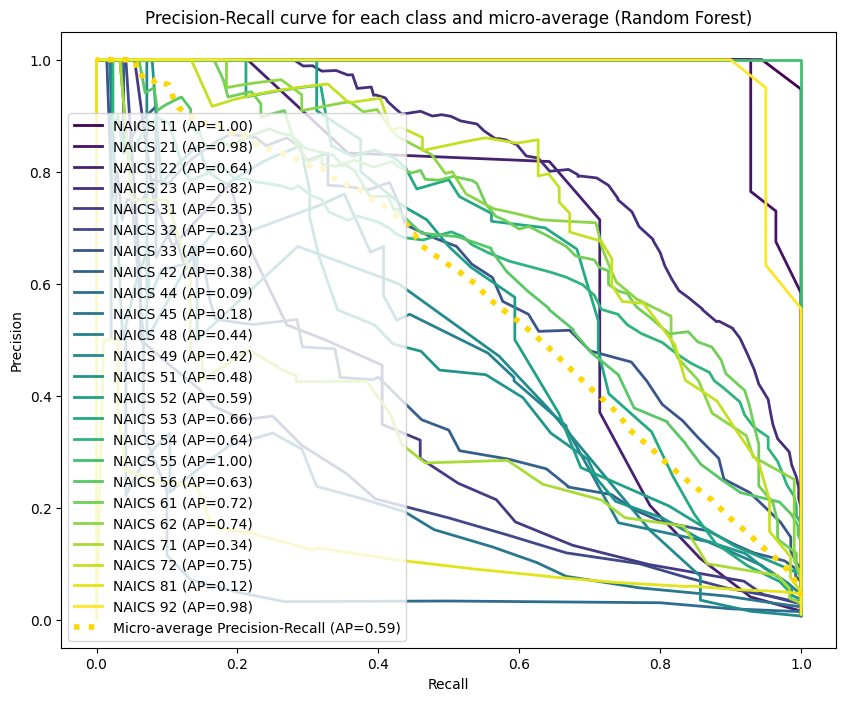

2024-04-23 21:40:56,726 - INFO - Average F1 Score Random Forest: 0.593277


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Preparar los datos, entrenar el modelo y hacer predicciones
# Asegúrate de que X_train, y_train, X_val, y_val ya están definidos y contienen los datos apropiados.

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)

# Matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report Random Forest:\n", report)
logging.info("F1 Score Random Forest: %f", f1)

# Binarizar las etiquetas en un formato one-vs-all para Random Forest
unique_classes = np.unique(y_train)  # Asegúrate de que esto contenga códigos NAICS reales
y_val_binarized = label_binarize(y_val, classes=unique_classes)

# Establecer el "ciclo" de colores para que coincida con el número de clases
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

# Calcular precisión y recall para cada clase
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

for i, code in enumerate(unique_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    # Asegúrate de que no haya división por cero al calcular el F1 score
    if np.any(precision[i]) and np.any(recall[i]):
        f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
        f1_scores.append(np.nanmax(f1))
    else:
        f1_scores.append(0)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))
for i, (color, code) in enumerate(zip(colors, unique_classes)):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i]))  # Usar códigos NAICS aquí

# Calcular la precisión y el recall promedios (micro-average)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Graficar la curva de precisión-recall promedio
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Random Forest)')
plt.legend(loc="best")
plt.show()

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Random Forest: %f", f1_average)


svm

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  27   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0]
 [  0   0   1   7   0   0   1   0   0   0   0   0   0   0   0   2   0   3
    0   0   0   0   0   0]
 [  0   0   0 266   0   0   5   4   0   0   1   0   1   0   2  12   0   9
    0   0   0   0   0   0]
 [  0   0   0   0   6   1   7  11   0   2   0   0   0   0   0   2   0   2
    0   0   0   6   0   0]
 [  0   0   0   2   0  15   8  12   0   2   0   0   0   0   0   5   0   1
    0   3   0   0   0   0]
 [  0   0   0  20   0   0  92  13   0   0   0   0   1   0   0   4   0   4
    0   1   1   0   1   0]
 [  0   0   0  13   1   0  11  77   0   2   2   0   0   0   0  13   0   7
    1   0   0   2   1   0]
 [  0   0   0   5   1   0   3  13   0   1   0   0   0   0   0   0   0   1
    1   0   0   5   0   0]
 [  0   0   0   3   0   0   1  12   0  17   1   0   0   0   0   0   0   

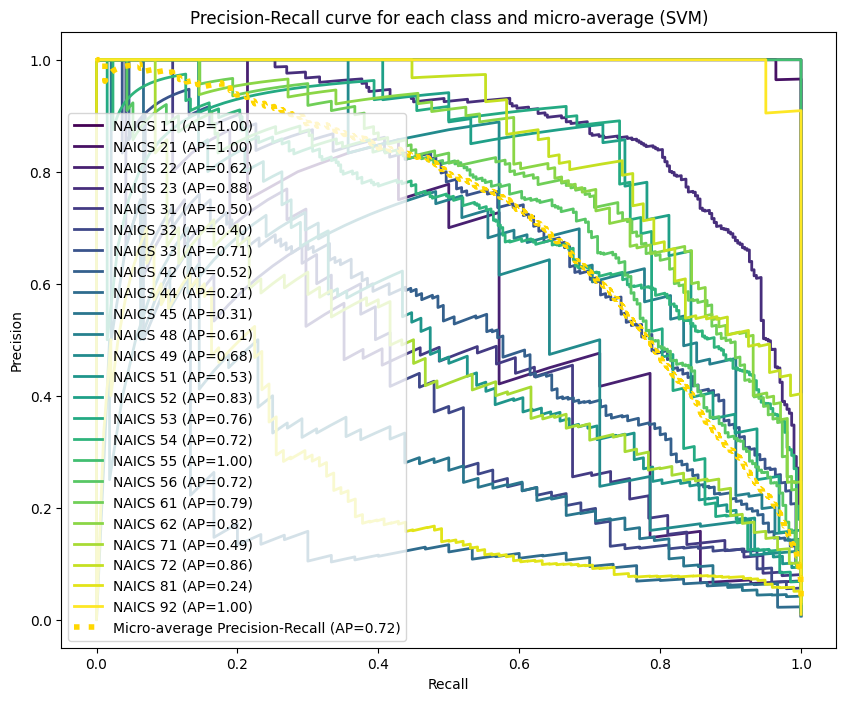

2024-04-23 21:46:17,887 - INFO - Average F1 Score SVM: 0.675616


In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import logging
from itertools import cycle

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Aplanar los embeddings y extraer las etiquetas
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

# Entrenar el modelo SVM
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred = svm_model.predict(X_val)
y_val_proba = svm_model.predict_proba(X_val)  # SVM también puede proporcionar probabilidades

# Matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report SVM:\n", report)
logging.info("F1 Score SVM: %f", f1)

# Binarizar las etiquetas en un formato one-vs-all para SVM
unique_classes = np.unique(y_train)  # Asegúrate de que esto contenga códigos NAICS reales
y_val_binarized = label_binarize(y_val, classes=unique_classes)

# Calcular precisión y recall para cada clase usando predict_proba
precision = dict()
recall = dict()
average_precision = dict()

# Establecer el "ciclo" de colores para que coincida con el número de clases
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

plt.figure(figsize=(10, 8))

# Graficar la curva de precisión-recall para cada clase
f1_scores = []
for i, (color, code) in enumerate(zip(colors, unique_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = 2 * (precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i]))  # Usar códigos NAICS aquí

# Calcular la precisión y el recall promedios (micro-average)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Graficar la curva de precisión-recall promedio
plt.plot(recall["micro"], precision["micro"],
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]),
         color='gold', linestyle=':', linewidth=4)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (SVM)')
plt.legend(loc="best")
plt.show()

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score SVM: %f", f1_average)


lda

2024-04-23 21:46:19,690 - INFO - F1 Score LDA: 0.672870
2024-04-23 21:46:19,692 - INFO - Mean Classification Error: 0.327446
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2024-04-23 21:46:19,698 - INFO - Mean Log Loss: 2.198725


Confusion Matrix:
 [[ 18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  27   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0]
 [  0   0   9   2   0   0   1   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1 256   0   6   5   5   2   0   1   1   1   0   5   5   0   8
    0   0   0   0   4   0]
 [  0   0   0   0  20   4   2   1   1   3   0   0   0   0   0   1   0   0
    0   0   0   4   1   0]
 [  0   0   0   1   0  26   4   6   1   4   1   0   0   0   0   2   0   1
    0   0   0   0   2   0]
 [  0   0   0  10   0   5  87  13   5   1   1   0   2   0   0   4   0   1
    0   1   2   0   5   0]
 [  0   0   0   4   3   1  11  73  13   4   2   0   1   0   0   9   0   4
    1   0   0   1   3   0]
 [  0   0   0   2   2   0   1   9   7   2   0   0   0   0   0   0   0   2
    1   0   0   2   2   0]
 [  0   0   1   2   3   2   0  11   0  19   1   0   1   0   0   1   0   

/tmp/ipykernel_26076/3494851146.py:63: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))


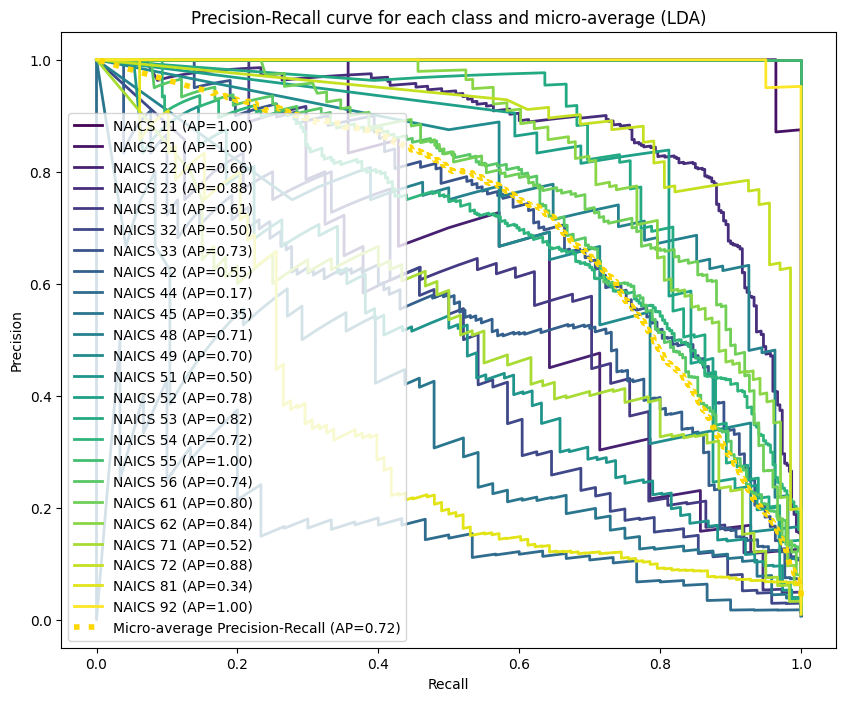

2024-04-23 21:46:20,807 - INFO - Average F1 Score LDA: 0.702781


In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Flatten embeddings and extract labels
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

# Train the LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = lda_model.predict(X_val)
y_val_proba = lda_model.predict_proba(X_val)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report LDA:\n", report)
logging.info("F1 Score LDA: %f", f1)

# Calculate mean classification error per class
classification_errors = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
mean_classification_error = np.mean(classification_errors)
logging.info("Mean Classification Error: %f", mean_classification_error)

# Log loss (cross-entropy loss) calculations
logloss = log_loss(y_val, y_val_proba)
logging.info("Mean Log Loss: %f", logloss)

# Binarize labels in a one-vs-all manner for LDA
unique_classes = np.unique(y_train)  # Ensure this includes actual NAICS codes
y_val_binarized = label_binarize(y_val, classes=unique_classes)

# Set color cycle for graphs
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

# Calculate precision, recall for each class using predict_proba
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

plt.figure(figsize=(10, 8))

for i, (color, code) in enumerate(zip(colors, unique_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i]))  # Use NAICS codes here

# Calculate and plot the precision-recall micro-average
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (LDA)')
plt.legend(loc="best")
plt.show()

# Log the average F1-score
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score LDA: %f", f1_average)

